In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [9]:
##DEL##
print(session.query(station).first().__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000182CC5AB910>, 'id': 1, 'latitude': 21.2716, 'elevation': 3.0, 'longitude': -157.8168, 'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'}


In [10]:
##DEL##
print(session.query(measurement).first().__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000182CC5DE550>, 'station': 'USC00519397', 'date': '2010-01-01', 'prcp': 0.08, 'id': 1, 'tobs': 65.0}


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()


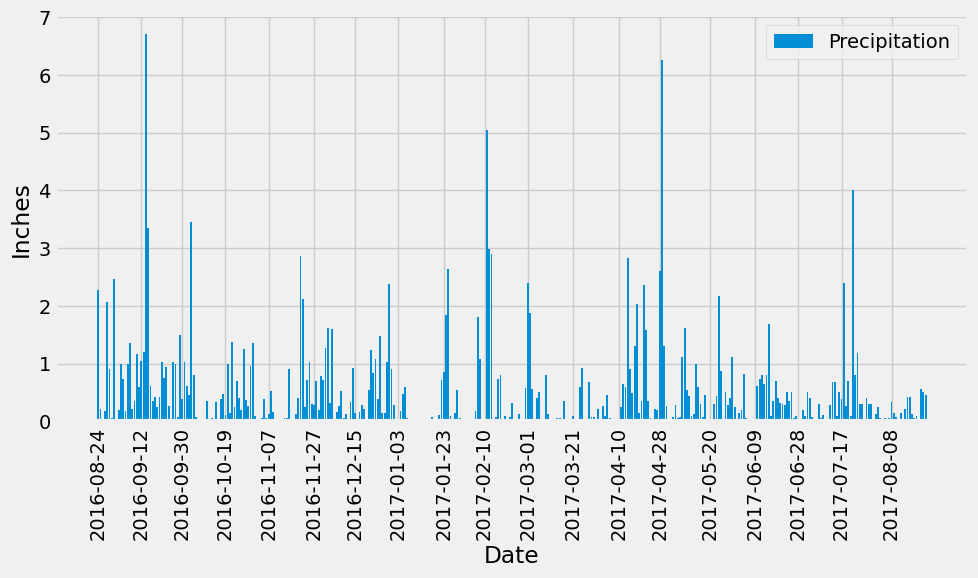

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
c_last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
TMP = c_last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp)
query = query.filter(measurement.date >= TMP)
results = query.all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
df = df.sort_values(by=['date'], ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))  
plt.bar(df['date'], df['prcp'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
N = 120
x_labels = df['date'][::N]
plt.xticks(x_labels, rotation=90)  
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
query2 = session.query(station).group_by(station.id).count()
query2

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active=session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ma_results = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station==most_active[0][0]).all()
ma_results



[(54.0, 85.0, 71.66378066378067)]

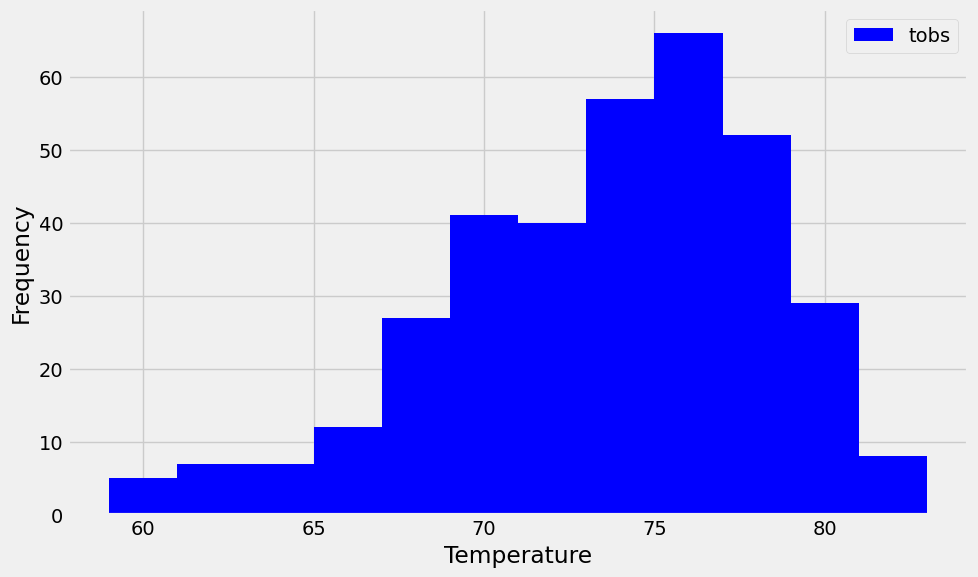

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active[0][0]).filter(measurement.date >= TMP).all()

value = [result[1] for result in data]

plt.figure(figsize=(10, 6))  
plt.hist(value, bins=12, label='tobs', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()